In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
cofile = '../out/sorted_conditions.txt'
rdir = '../data/rnaseq/'
obo = '../out/SGD_slim.obo'
gaf = '../out/SGD_slim.tsv'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import os
import numpy as np
import pandas as pd
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy

In [4]:
def read_de_table(fname, 
                  f=None):
    if f is None:
        f = {}
    
    m = pd.read_table(fname,
                      sep=',',
                      index_col=0).dropna()
    m.index = [f.get(x, x) for x in m.index]
    pseudo = sorted([x for x in m['padj'].unique() if x != 0])[0]
    m[m['padj'] == 0] = pseudo
    
    return m

In [5]:
def plot_scores(g, c, s, strains,
                gn=None, ng=None, nc=None):
    v = s.loc[(slice(None),
               sorted(g)),][
        'score'].to_frame().pivot_table(index='gene',
                                        columns=['strain', 'condition'],
                                        values='score')
    v = v.reindex(sorted(g)).rename(index=gn)
    v = v.T.loc[(slice(None), c),].T
    v = v.T.reset_index().set_index('strain').loc[strains
        ].reset_index().set_index(['strain',
        'condition']).T
    idx = v.T.mean().sort_values().index
    v = v.loc[idx]
    p = s.loc[(slice(None),
               sorted(g)),][
        'phenotype'].to_frame().pivot_table(index='gene',
                                        columns=['strain', 'condition'],
                                        values='phenotype')
    p = p.reindex(sorted(g)).rename(index=gn)
    p = p.T.loc[(slice(None), c),].T
    p = p.T.reset_index().set_index('strain').loc[strains
        ].reset_index().set_index(['strain',
        'condition']).T
    p = p.loc[idx]
    p = p.values.astype(str)
    p[p == '1.0'] = '-'
    p[p == '0.0'] = ''

    colors = []
    for i, strain in enumerate(strains):
        for x in range(v.T.loc[strain].shape[0]):
            colors.append(i)
    colors = np.array(colors)

    if ng is None:
        ng = len(g) * 0.5
    if nc is None:
        nc = len(c) * 0.5

    plt.figure(figsize=(nc, ng))

    gs = plt.GridSpec(2, 2,
                      hspace=0,
                      wspace=0.1,
                      height_ratios=[0.15, 6],
                      width_ratios=[6, 0.15])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    plt.sca(ax2)
    hm = sns.heatmap(v,
                     cmap=cmap,
                     vmin=-5,
                     vmax=5,
                     cbar=True,
                     cbar_ax=ax3,
                     annot=p,
                     fmt='s',
                     annot_kws={'size': 20,
                                'weight': 'bold',
                                'va': 'center'})
    plt.gca().set_xticklabels(['-'.join(x.get_text().split('-')[1:])
                               for x in plt.gca().get_xticklabels()])
    plt.xlabel('Conditions')
    plt.ylabel('Genes')
    cbar_ax = plt.gcf().axes[-1]
    cbar_ax.set_ylabel('S-score', rotation=270, labelpad=10)

    plt.sca(ax1)
    plt.imshow(colors.reshape(-1, 1).T,
               aspect='auto',
               cmap=cmap1,
               vmin=0)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Strains')
    plt.gca().xaxis.set_label_position('top') 
    sns.despine(left=True,
                bottom=True)
    
    return idx

In [6]:
def plot_de(g, s, strains,
            gn=None, ng=None, nc=None):
    v = s.loc[(slice(None),
               g),].pivot_table(index='gene',
        columns='strain',
        values='log2FoldChange')
    v = v.loc[g]
    p = s.loc[(slice(None),
               g),].pivot_table(index='gene',
        columns='strain',
        values='padj')
    p= p.loc[g]
    p[p <= 1E-4] = 0
    p[p > 1E-4] = 1
    p = p.values.astype(str)
    p[p == '0.0'] = '-'
    p[p == '1.0'] = ''
    
    colors = []
    for i, strain in enumerate(strains):
        for x in range(v.T.loc[strain].shape[0]):
            colors.append(i+1)
    colors = np.array(colors)

    if ng is None:
        ng = len(g) * 0.5
    if nc is None:
        nc = len(c) * 0.5

    plt.figure(figsize=(nc, ng))

    gs = plt.GridSpec(2, 2,
                      hspace=0,
                      wspace=0.1,
                      height_ratios=[0.15, 6],
                      width_ratios=[6, 0.15])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    plt.sca(ax2)
    hm = sns.heatmap(v,
                     cmap='vlag',
                     vmin=-4,
                     vmax=4,
                     cbar=True,
                     cbar_ax=ax3,
                     annot=p,
                     fmt='s',
                     annot_kws={'size': 20,
                                'weight': 'bold',
                                'va': 'center'})
    plt.gca().set_xticklabels(['-'.join(x.get_text().split('-')[1:])
                               for x in plt.gca().get_xticklabels()])
    plt.xlabel('Conditions')
    plt.ylabel('Genes')
    cbar_ax = plt.gcf().axes[-1]
    cbar_ax.set_ylabel('$log_{2}(FC)$', rotation=270, labelpad=10)

    plt.sca(ax1)
    plt.imshow(colors.reshape(-1, 1).T,
               aspect='auto',
               cmap=cmap1,
               vmin=0)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Strains')
    plt.gca().xaxis.set_label_position('top') 
    sns.despine(left=True,
                bottom=True)

In [7]:
def go_enrich(pop, study,
              go, obodag):
    res = []
    goeaobj = GOEnrichmentStudy(pop,
                                go, obodag,
                                propagate_counts=False,
                                alpha=0.05,
                                methods=['fdr_bh'],
                                log=None)
    goe = goeaobj.run_study(study,
                            log=None)
    for xx in goe:
        res.append([xx.goterm.id,
                    xx.goterm.namespace,
                    xx.goterm.depth,
                    xx.goterm.name,
                    '%d/%d' % xx.ratio_in_study,
                    '%d/%d' % xx.ratio_in_pop,
                    xx.p_uncorrected,
                    xx.p_fdr_bh])
    g = pd.DataFrame(res,
                     columns=['go',
                              'go_namespace',
                              'go_depth',
                              'go_name',
                              'ratio_in_study',
                              'ratio_in_population',
                              'pvalue',
                              'qvalue'])
    g = g[g['qvalue'] < 0.01]
    return g

In [8]:
cmap = sns.diverging_palette(76, 217, l=89, n=100, center="dark", as_cmap=True)
cmap.set_bad(sns.xkcd_rgb['grey'], alpha=0.55)

In [9]:
co = [x.rstrip()
      for x in open(cofile)]

In [10]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
rgn = g[g[1] == 'ORF'].set_index(4)[3].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [11]:
obodag = GODag(obo)
go = {}
rgo = {}
for l in open(gaf):
    gene, gos = l.rstrip().split()
    go[rgn.get(gene, gene)] = set(gos.split(';')) - {''}
    for gterm in set(gos.split(';')) - {''}:
        rgo[gterm] = rgo.get(gterm, set())
        rgo[gterm].add(gene)

load obo file ../out/SGD_slim.obo
../out/SGD_slim.obo: fmt(1.2) rel(None) 165 GO Terms


In [12]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
genes = sorted(genes)

In [13]:
s = pd.read_table(scores)
s = s[s['gene'] != 'WT']
s = s.set_index(['strain', 'gene', 'condition']).sort_index()
s = s[~s.index.duplicated(keep='last')]
s = s.loc[(slice(None), genes),]

s.loc[s[s['qvalue'] <= 0.05].index, 'phenotype'] = 1
s.loc[s[s['qvalue'] > 0.05].index, 'phenotype'] = 0

In [14]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}
cmap1 = colors.ListedColormap([cstrains[strain]
                               for strain in strains])

In [15]:
r = []
for fname, strain in zip([os.path.join(rdir, x)
                          for x in ['UWOPS87_2421.csv',
                                    'Y55.csv',
                                    'YPS606.csv']],
                         ['UWOP', 'Y55', 'YPS']):
    df = read_de_table(fname)
    df['strain'] = strain
    df.index = [gn.get(x, x) for x in df.index]
    df.index.name = 'gene'
    r.append(df)
r = pd.concat(r)
r = r.reset_index().set_index(['strain', 'gene']).sort_index()

In [16]:
rc = []
for fname, strain in zip([os.path.join(rdir, x)
                          for x in ['UWOPS87_2421.caff.csv',
                                    'Y55.caff.csv',
                                    'YPS606.caff.csv']],
                         ['UWOP', 'Y55', 'YPS']):
    df = read_de_table(fname)
    df['strain'] = strain
    df.index = [gn.get(x, x) for x in df.index]
    df.index.name = 'gene'
    rc.append(df)
rc = pd.concat(rc)
rc = rc.reset_index().set_index(['strain', 'gene']).sort_index()

In [17]:
d = pd.read_table(dev)
d = d.set_index('gene').sort_index().loc[genes].reset_index()
d = d.set_index('condition').sort_index()

In [18]:
malgly = sorted({x for x in d.index
                 if x.startswith('Maltose') or x.startswith('Glycerol')})
nacl = sorted({x for x in d.index
               if x.startswith('NaCl')})
caff = sorted({x for x in d.index
               if x.startswith('Caff')})
aa = sorted({x for x in d.index
             if x.startswith('aa ')})
conds = malgly + nacl + caff + aa

In [19]:
# genes = [# 'Sln1',
#          # 'Ypd1',
#          'Ssk1',
#          'hkr1', 'Msb2', 'Sho1', 'opy2',
#          # 'cdc42',
#          # 'ste20',
#          'Ssk2', 'Ssk22', 'ste50',
#          # 'Ste11',
#          'Pbs2',
#          # 'ptc1',
#          'ptc3',
#          'Hog1',
#          'Hot1', 'Sko1', 'Msn2',
#          # 'Msn4',
#          'Smp1',
#          # 'Gpd1'
#         ]

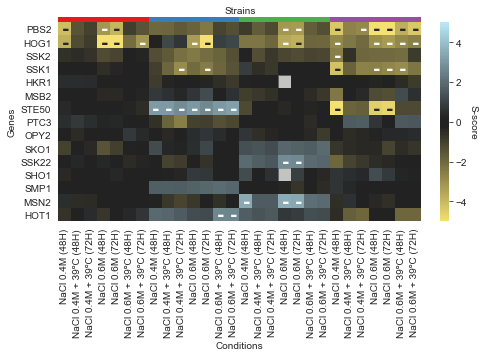

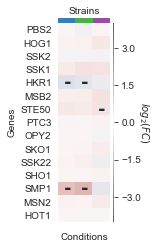

In [20]:
c = ['NaCl 0.4M (48H)',
     'NaCl 0.6M (48H)',
     'NaCl 0.6M (72H)']
s1 = 'Y55'
s2 = 'YPS'
qvalue = 1E-4

genes = ['Ssk1',
         'hkr1', 'Msb2', 'Sho1', 'opy2',
         'Ssk2', 'Ssk22', 'ste50',
         'Pbs2', 'ptc3', 'Hog1',
         'Hot1', 'Sko1', 'Msn2',
         'Smp1']
genes = [rgn.get(x.upper(), x.upper())
         for x in genes]

idx = plot_scores(genes,
            nacl, s, strains, gn=gn,
            nc=len(nacl), ng=len(genes)*0.25)
plt.savefig('heatmap_nacl_hog.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_nacl_hog.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plot_de(idx, r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(idx)*0.25)
plt.savefig('eheatmap_nacl_hog.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_nacl_hog.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [21]:
go_enrich(set(d['gene'].unique()),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue
0,GO:0006970,biological_process,1,response to osmotic stress,15/15,69/3786,1.619347e-27,2.607148e-25
1,GO:0023052,biological_process,1,signaling,11/15,165/3786,9.112603e-13,7.335645e-11
2,GO:0006468,biological_process,1,protein phosphorylation,7/15,120/3786,1.407671e-07,7.554500e-06
3,GO:0009408,biological_process,1,response to heat,5/15,47/3786,6.492439e-07,2.613207e-05
98,GO:0030427,cellular_component,1,site of polarized growth,5/15,165/3786,3.114174e-04,8.356366e-03
121,GO:0019899,molecular_function,1,enzyme binding,4/15,38/3786,1.088898e-05,3.506252e-04


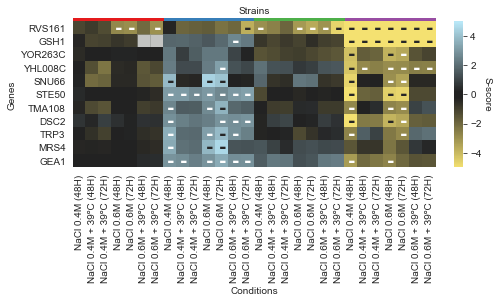

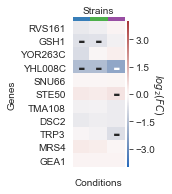

In [22]:
c = ['NaCl 0.4M (48H)',
     'NaCl 0.6M (48H)',
     'NaCl 0.6M (72H)']
s1 = 'Y55'
s2 = 'YPS'
qvalue = 1E-4

t = d[((d['strain1'] == s1) & (d['strain2'] == s2)) |
      ((d['strain1'] == s2) & (d['strain2'] == s1))].loc[c]
t1 = pd.concat([t[(t['strain1'] == s1) &
                  (t['phenotype1']) &
                  (t['scores1'] > 0) &
                  (t['qvalue'] < qvalue)],
                t[(t['strain2'] == s1) &
                  (t['phenotype2']) &
                  (t['scores2'] > 0) &
                  (t['qvalue'] < qvalue)]])
t2 = pd.concat([t[(t['strain1'] == s2) &
                  (t['phenotype1']) &
                  (t['scores1'] < 0) &
                  (t['qvalue'] < qvalue)],
                t[(t['strain2'] == s2) &
                  (t['phenotype2']) &
                  (t['scores2'] < 0) &
                  (t['qvalue'] < qvalue)]])

genes = sorted(pd.concat([t1, t2])['gene'].unique())

idx = plot_scores(genes,
            nacl, s, strains, gn=gn,
            nc=len(nacl), ng=len(genes)*0.25)
plt.savefig('heatmap_nacl.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_nacl.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plot_de(idx, r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)
plt.savefig('eheatmap_nacl.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_nacl.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [23]:
go_enrich(set(d['gene'].unique()),
          set(t1['gene'].unique()),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue


In [24]:
go_enrich(set(d['gene'].unique()),
          set(t2['gene'].unique()),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue


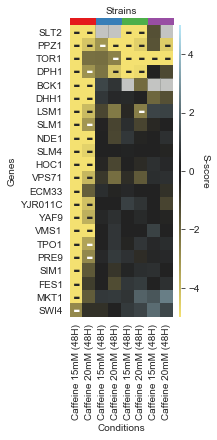

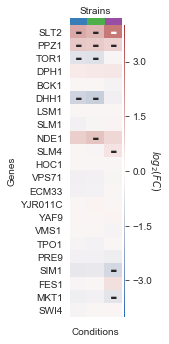

In [25]:
c = ['Caffeine 15mM (48H)']
s1 = 'S288C'
qvalue = 1E-4

t = d[((d['strain1'] == s1) | (d['strain2'] == s1))].loc[c]
t1 = pd.concat([t[(t['strain1'] == s1) &
                  (t['phenotype1']) &
                  (t['scores1'] < 0) &
                  (t['qvalue'] < qvalue)],
                t[(t['strain2'] == s1) &
                  (t['phenotype2']) &
                  (t['scores2'] < 0) &
                  (t['qvalue'] < qvalue)]])

genes = pd.concat([t1])['gene'].unique()

idx = plot_scores(genes,
            caff, s, strains, gn=gn,
            nc=len(caff), ng=len(genes)*0.25)

plt.savefig('heatmap_caff.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_caff.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

plot_de(idx, rc,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)

plt.savefig('eheatmap_caff.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_caff.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [26]:
go_enrich(set(d['gene'].unique()),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue


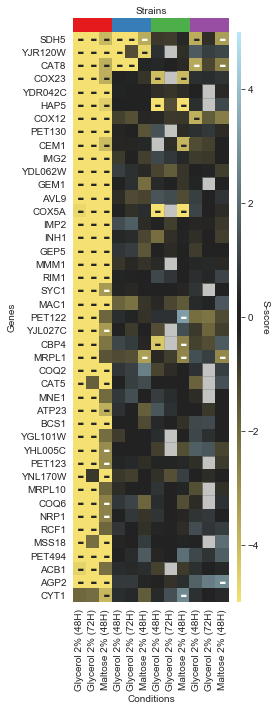

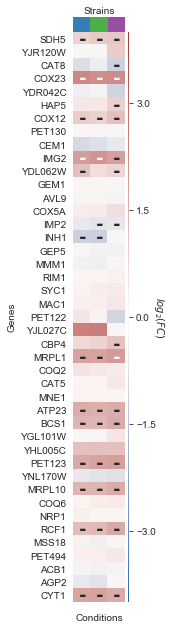

In [27]:
c = ['Glycerol 2% (48H)',
     'Maltose 2% (48H)']
s1 = 'S288C'
qvalue = 1E-4

t = d[((d['strain1'] == s1) | (d['strain2'] == s1))].loc[c]
t1 = pd.concat([t[(t['strain1'] == s1) &
                  (t['phenotype1']) &
                  (t['scores1'] < 0) &
                  (t['qvalue'] < qvalue)],
                t[(t['strain2'] == s1) &
                  (t['phenotype2']) &
                  (t['scores2'] < 0) &
                  (t['qvalue'] < qvalue)]])

genes = pd.concat([t1])['gene'].unique()

idx = plot_scores(genes,
            malgly, s, strains, gn=gn,
            nc=len(malgly), ng=len(genes)*0.25)

plt.savefig('heatmap_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

plot_de(idx,
        r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)

plt.savefig('eheatmap_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [28]:
go_enrich(set(d['gene'].unique()),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue
0,GO:0007005,biological_process,1,mitochondrion organization,19/43,161/3786,1.014893e-15,1.633978e-13
1,GO:0032543,biological_process,1,mitochondrial translation,6/43,26/3786,2.910654e-07,1.171538e-05
2,GO:0045333,biological_process,2,cellular respiration,5/43,50/3786,2.161077e-04,6.958669e-03
98,GO:0005739,cellular_component,1,mitochondrion,28/43,613/3786,5.631465e-13,4.533329e-11
99,GO:0005740,cellular_component,1,mitochondrial envelope,15/43,182/3786,4.439086e-10,2.382310e-08


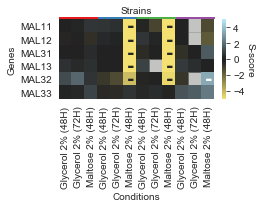

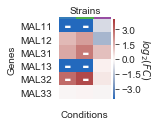

In [29]:
c = ['Glycerol 2% (48H)',
     'Maltose 2% (48H)']
s1 = 'S288C'
qvalue = 1E-4

genes = [x for x in d['gene'].unique()
         if gn.get(x, x).startswith('MAL')
         or gn.get(x, x).startswith('AGT')
         or gn.get(x, x).startswith('MPH')]

idx = plot_scores(genes,
            malgly, s, strains, gn=gn,
            nc=len(malgly), ng=len(genes)*0.25)

plt.savefig('heatmap_MAL_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_MAL_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

plot_de(idx,
        r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)

plt.savefig('eheatmap_MAL_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_MAL_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [30]:
go_enrich(set(d['gene'].unique()),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue
0,GO:0005975,biological_process,1,carbohydrate metabolic process,5/6,141/3786,3.891711e-07,0.000063
1,GO:0009311,biological_process,2,oligosaccharide metabolic process,3/6,18/3786,1.789754e-06,0.000144


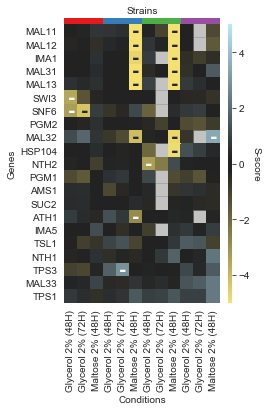

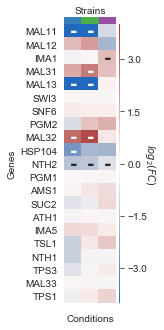

In [31]:
c = ['Glycerol 2% (48H)',
     'Maltose 2% (48H)']
s1 = 'S288C'
qvalue = 1E-4

genes = [x for x in d['gene'].unique()
         if gn.get(x, x).startswith('MAL')
         or gn.get(x, x).startswith('AGT')
         or gn.get(x, x).startswith('MPH')
         or gn.get(x, x).startswith('SUC')
         or x in rgo['GO:0009311']
#          or x in rgo['GO:0005975']
#          or x in ['YPR196W',
#                   'YDL247W',
#                   'YJR160C']
#          or x in ['YJL221C',
#                   'YJL216C',
#                   'YJR160C',
#                   'YOL157C',
#                   'YPR196W',
#                   'YBR050C',
#                   'YBR298C',
#                   'YBR299W',
#                   'YDL247W',
#                   'YGR287C',
#                   'YGR290W',
#                   'YGR289C',
#                   'YGR292W',
#                   'YIL172C']
        ]

idx = plot_scores(genes,
            malgly, s, strains, gn=gn,
            nc=len(malgly), ng=len(genes)*0.25)

plt.savefig('heatmap_oligos_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_oligos_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

plot_de(idx,
        r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)

plt.savefig('eheatmap_MAL_malgly.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_MAL_malgly.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

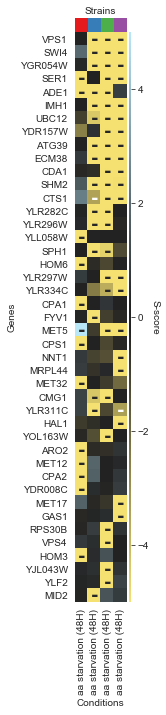

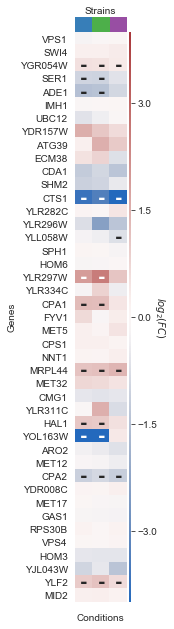

In [32]:
c = aa
qvalue = 1E-4

t = d[((d['strain1'] == s1) | (d['strain2'] == s1))].loc[c]
ts = []
for strain in strains:
    t1 = pd.concat([t[(t['strain1'] == strain) &
                      (t['phenotype1']) &
                      (t['scores1'] < 0) &
                      (t['qvalue'] < qvalue)],
                    t[(t['strain2'] == strain) &
                      (t['phenotype2']) &
                      (t['scores2'] < 0) &
                      (t['qvalue'] < qvalue)]])
    ts.append(t1)

genes = pd.concat(ts)['gene'].unique()

idx = plot_scores(genes,
            aa, s, strains, gn=gn,
            nc=len(aa), ng=len(genes)*0.25)

plt.savefig('heatmap_aa.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_aa.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

plot_de(idx, r,
        ['Y55', 'UWOP', 'YPS'], gn=gn,
        nc=1, ng=len(genes)*0.25)

plt.savefig('eheatmap_aa.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('eheatmap_aa.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [33]:
go_enrich(set(d['gene'].unique()),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue
0,GO:0006520,biological_process,1,cellular amino acid metabolic process,9/43,110/3786,0.000003,0.000422
